In [1]:
import os
import torch
import torch.nn as nn
from skimage import io
from torch.utils.data import DataLoader
from utilities import preprocess_image, postprocess_image
from torchvision import transforms
import torch.nn.functional as F
import tqdm as tqdm
from PIL import Image
import numpy as np
import wandb
from example_inference import example_inference
from briarmbg import BriaRMBG
from skimage.color import rgba2rgb, gray2rgb

c:\Users\PIX-DTP-007\anaconda3\envs\rembg_train\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, mask_dir, device):
        self.image_paths_list = image_dir
        self.mask_paths_list = mask_dir
        self.device = device
        self.model_input_size = [1024, 1024]

    def preprocess_image(self, im: np.ndarray, model_input_size: list) -> torch.Tensor:
        if len(im.shape) < 3:
            im = im[:, :, np.newaxis]
        im_tensor = torch.tensor(im, dtype=torch.float32).permute(2, 0, 1)  # CxHxW
        im_tensor = F.interpolate(im_tensor.unsqueeze(0), size=model_input_size, mode='bilinear', align_corners=False)
        im_tensor = im_tensor.squeeze(0).type(torch.float32)
        image = im_tensor / 255.0
        image = transforms.Normalize([0.5, 0.5, 0.5], [1.0, 1.0, 1.0])(image)
        return image
    

    def preprocess_mask(self, mask: np.ndarray, model_input_size: list) -> torch.Tensor:
        if len(mask.shape) == 2:
            mask = mask[np.newaxis, :, :]  # Adding channel dimension
        mask_tensor = torch.tensor(mask, dtype=torch.float32)   # CxHxW
        mask_tensor = F.interpolate(mask_tensor.unsqueeze(0), size=model_input_size, mode='nearest').squeeze(0)  # remove align_corners
        mask_tensor = (mask_tensor > 0.5).float()  # binarization
        return mask_tensor


    def __len__(self):
        return len(self.image_paths_list)

    def __getitem__(self, idx):
        img_path = self.image_paths_list[idx]
        mask_path = self.mask_paths_list[idx]

        orig_im = io.imread(img_path)
        # Convert to RGB if image is grayscale
        if len(orig_im.shape) == 2 or orig_im.shape[2] == 1:
            orig_im = gray2rgb(orig_im)

        # Convert to RGB if image is RGBA
        if orig_im.shape[2] == 4:
            orig_im = rgba2rgb(orig_im)

        orig_mask = io.imread(mask_path, as_gray=True)

        #print(orig_im.shape)
        #print(orig_mask.shape)

        image = self.preprocess_image(orig_im, self.model_input_size).to(self.device)
        mask = self.preprocess_mask(orig_mask, self.model_input_size).to(self.device)

        return image, mask


def log_evaluation_images(model, image_paths, true_mask_paths, epoch):
    model.eval()
    with torch.no_grad():
        image_np_list = []
        mask_np_list = []
        pred_mask_np_list = []
        for i, (img_path, mask_path) in enumerate(zip(image_paths, true_mask_paths)):

            # Load image and mask
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            img_np = np.array(img)
            mask_np = np.array(mask)
            # Get predicted mask from example_inference
            pred_mask_np = example_inference(img_path, model)

            image_np_list.append(img_np)
            mask_np_list.append(mask_np)
            pred_mask_np_list.append(pred_mask_np)

        return image_np_list, mask_np_list, pred_mask_np_list 

        

# FineTuning function
def finetune_model(image_dir, mask_dir, model_path, epochs, batch_size, learning_rate):
    # Initialize wandb
    wandb.init(project="rmbg-finetuning-last-final")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Dataset and dataloader
    dataset = CustomDataset(image_dir=image_dir, mask_dir=mask_dir, device=device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Load local weights(.pth)
    model = BriaRMBG()
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model = model.to(device)
    
    # Optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCEWithLogitsLoss()

    # train loop
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)[0][0]
            
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_epoch_loss = epoch_loss / len(image_dir)   
        # Log the loss to wandb
        wandb.log({"epoch": epoch+1, "loss": avg_epoch_loss})

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader)}')

        if epoch % 10 == 0:
            image_np_list, mask_np_list, pred_mask_np_list = log_evaluation_images(model, eval_img_list, eval_masks_list, epoch)

            # Log the images to wandb
            wandb.log({
            "epoch": epoch+1,
            "Original Image": [wandb.Image(img) for img in image_np_list],
            "Bria Mask": [wandb.Image(bria_mask) for bria_mask in mask_np_list],
            "Predicted Mask": [wandb.Image(pred_mask) for pred_mask in pred_mask_np_list]})
            
            torch.save(model.state_dict(), './weight_files_checkpoints/finetuned_model-ep'+ str(epoch) +'.pth')
    torch.save(model.state_dict(), './weight_files_checkpoints/final-finetuned-model.pth')
    del model

In [10]:
import pandas as pd
df_cleaned_train = pd.read_csv(".\\dataset-csv\\cleaned_train_data.csv")
evaluation_df = pd.read_csv("./dataset-csv/evalution-data.csv")

In [11]:
images_paths_list = df_cleaned_train["images_path"]
masks_paths_list = df_cleaned_train["masks_path"]

eval_img_list = evaluation_df["images_path"]
eval_masks_list =  evaluation_df["masks_path"]

In [12]:
print(len(images_paths_list))
print(len(masks_paths_list))

15036
15036


In [13]:
torch.cuda.is_available()

True

In [14]:
!nvidia-smi

Thu Jul 11 11:27:54 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.52                 Driver Version: 551.52         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090 Ti   WDDM  |   00000000:01:00.0  On |                    0 |
|  0%   37C    P8              9W /  450W |    1185MiB /  23028MiB |     25%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
# Launch FineTuning
finetune_model(image_dir= images_paths_list,
               mask_dir= masks_paths_list,
               model_path='./model.pth',
               epochs=500,
               batch_size=8,
               learning_rate=1e-4)

Epoch 1/500, Loss: 0.6761574844730661
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


Epoch 2/500, Loss: 0.6680907538913666
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


Epoch 3/500, Loss: 0.6672804010041217
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


Epoch 4/500, Loss: 0.6668814265030496
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


In [92]:
eval_folder = "d:\\s3_dataset_entire\\RMBG_finetune\\evaluation"
eval_masks_list = [os.path.join(eval_folder, i) for i in os.listdir(eval_folder) if "mask" in i]
eval_img_list = [os.path.join(eval_folder, i) for i in os.listdir(eval_folder) if not("mask" in i)]

print(eval_img_list)
print(eval_masks_list)

['d:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_11.png', 'd:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_22.png', 'd:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_33.png', 'd:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_44.png']
['d:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_11_mask.png', 'd:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_22_mask.png', 'd:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_33_mask.png', 'd:\\s3_dataset_entire\\RMBG_finetune\\evaluation\\podium-bgrm_44_mask.png']


In [93]:
evaluation_df = pd.DataFrame({
    "images_path" : eval_img_list,
    "masks_path" : eval_masks_list
})
evaluation_df.to_csv("./dataset-csv/evalution-data.csv")

In [80]:
evaluation_df.head(
)

,images_path,masks_path
0,d:\s3_dataset_entire\RMBG_finetune\evaluation\...,d:\s3_dataset_entire\RMBG_finetune\evaluation\...
1,d:\s3_dataset_entire\RMBG_finetune\evaluation\...,d:\s3_dataset_entire\RMBG_finetune\evaluation\...
2,d:\s3_dataset_entire\RMBG_finetune\evaluation\...,d:\s3_dataset_entire\RMBG_finetune\evaluation\...
3,d:\s3_dataset_entire\RMBG_finetune\evaluation\...,d:\s3_dataset_entire\RMBG_finetune\evaluation\...


In [73]:
# shuffled_images_masks_df.to_csv("./dataset-csv/seg_img-mask.csv")

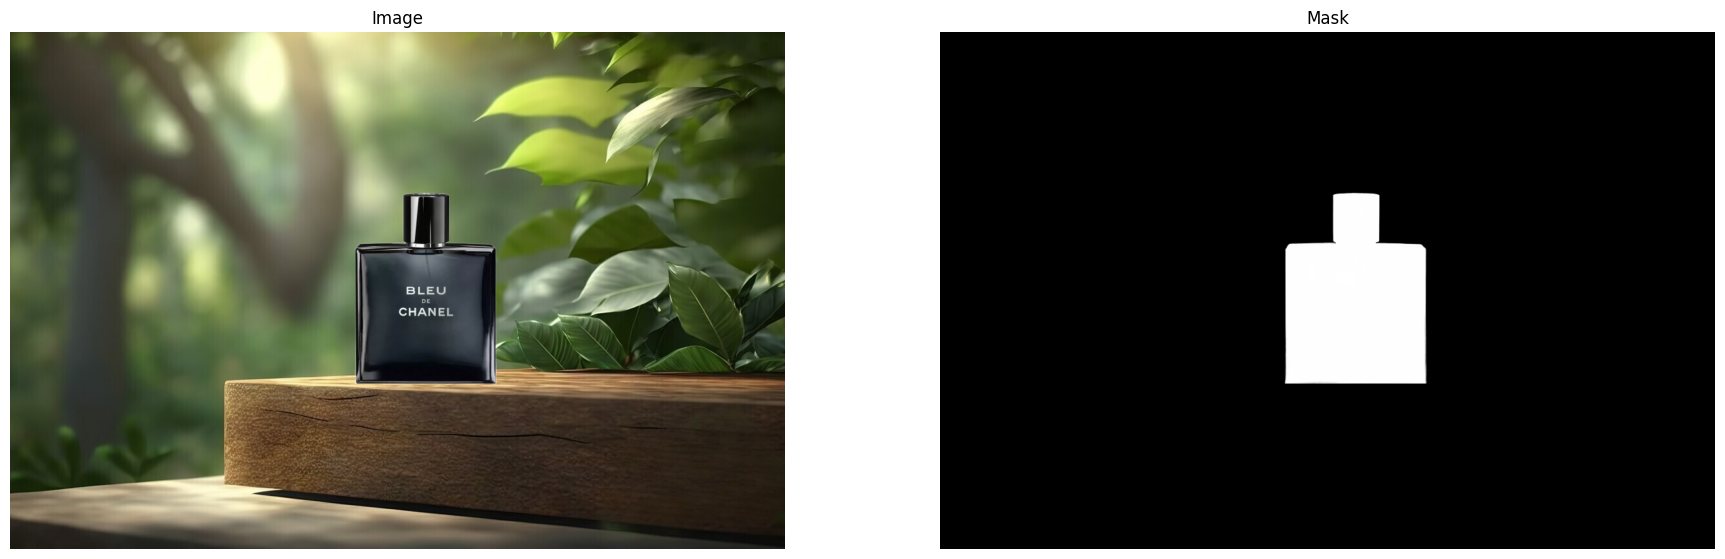

In [10]:
plot_image_and_mask(df_cleaned_train, 1500)

#### Get images and corresponding masks

In [28]:
import os

def get_image_files_dir(directory):
    image_files_list = []
    mask_files_list = []

    image_extensions = ('.jpg', '.jpeg', '.png')
    target_subdirs = {"composite", "product_id"}
    
    for dirpath, dirnames, filenames in os.walk(directory):
        # Check if any of the target subdirectories are in the current directory path
        if any(subdir in dirpath.split(os.sep) for subdir in target_subdirs):
            images_count = 0
            for filename in filenames:
                if filename.lower().endswith(image_extensions):
                    file_path = os.path.join(dirpath, filename)
                    if os.path.exists(file_path):
                        image_files_list.append(file_path)
                        images_count += 1 
            for i in range(0, images_count):
                id_folder, temp_folder = os.path.split(dirpath)
                mask_folder = os.path.join(id_folder, "mask")
                mask_file = os.listdir(mask_folder)[0]
                abs_mask_path = os.path.join(mask_folder, mask_file)
                mask_files_list.append(abs_mask_path)

    return image_files_list, mask_files_list

train_image_files, mask_files_list = get_image_files_dir("d:\\s3_dataset_entire\\S3_entire-dataset\\")


In [29]:
print("images_count = ", len(train_image_files), "masks_count = ", len(mask_files_list))

images_count =  55908 masks_count =  55908


In [31]:
print_count = 0 
for i in range(len(train_image_files)):
    print(train_image_files[i] , mask_files_list[i])
    print_count += 1
    if print_count > 7:
        break

d:\s3_dataset_entire\S3_entire-dataset\1686481233_40d40adf30c0433d9b45ddb060a4ae39\composite\compsoite.png d:\s3_dataset_entire\S3_entire-dataset\1686481233_40d40adf30c0433d9b45ddb060a4ae39\mask\mask.png
d:\s3_dataset_entire\S3_entire-dataset\1686481500_a35625f7f02d4c588bf86e61c85b648f\composite\composite.png d:\s3_dataset_entire\S3_entire-dataset\1686481500_a35625f7f02d4c588bf86e61c85b648f\mask\mask.png
d:\s3_dataset_entire\S3_entire-dataset\1686481814_dec65848431b4f00bd86dc6c419d4fc0\composite\composite.png d:\s3_dataset_entire\S3_entire-dataset\1686481814_dec65848431b4f00bd86dc6c419d4fc0\mask\mask.png
d:\s3_dataset_entire\S3_entire-dataset\1686489880_0ff76c3a43024383ac625823ed34c771\composite\composite.png d:\s3_dataset_entire\S3_entire-dataset\1686489880_0ff76c3a43024383ac625823ed34c771\mask\mask.png
d:\s3_dataset_entire\S3_entire-dataset\1686490713_3f4a71e8a4274d5c93be244dc4d0ec00\composite\composite.png d:\s3_dataset_entire\S3_entire-dataset\1686490713_3f4a71e8a4274d5c93be244dc4d

In [33]:
import pandas as pd
images_masks_df = pd.DataFrame({
    "images_path" : train_image_files,
    "masks_path" : mask_files_list })

In [7]:
import matplotlib.pyplot as plt
import cv2

def plot_image_and_mask(images_masks_df, index):
    # Read the image and mask file paths from the DataFrame
    image_path = images_masks_df.loc[index, 'images_path']
    mask_path = images_masks_df.loc[index, 'masks_path']
    
    # Read the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Assuming mask is a grayscale image

    # Plot the image and mask side by side
    fig, axs = plt.subplots(1, 2, figsize=(22, 15))

    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# Example usage: plot the first image and mask pair
# plot_image_and_mask(images_masks_df, 55907)


##### Randomly shuffling rows of the dataframe 

In [43]:
# Shuffle the DataFrame rows randomly with a fixed seed
shuffled_images_masks_df = images_masks_df.sample(frac=1, random_state=48).reset_index(drop=True)
shuffled_images_masks_df.head()


,images_path,masks_path
0,d:\s3_dataset_entire\S3_entire-dataset\1712055...,d:\s3_dataset_entire\S3_entire-dataset\1712055...
1,d:\s3_dataset_entire\S3_entire-dataset\1690749...,d:\s3_dataset_entire\S3_entire-dataset\1690749...
2,d:\s3_dataset_entire\S3_entire-dataset\1703248...,d:\s3_dataset_entire\S3_entire-dataset\1703248...
3,d:\s3_dataset_entire\S3_entire-dataset\1702297...,d:\s3_dataset_entire\S3_entire-dataset\1702297...
4,d:\s3_dataset_entire\S3_entire-dataset\1690633...,d:\s3_dataset_entire\S3_entire-dataset\1690633...


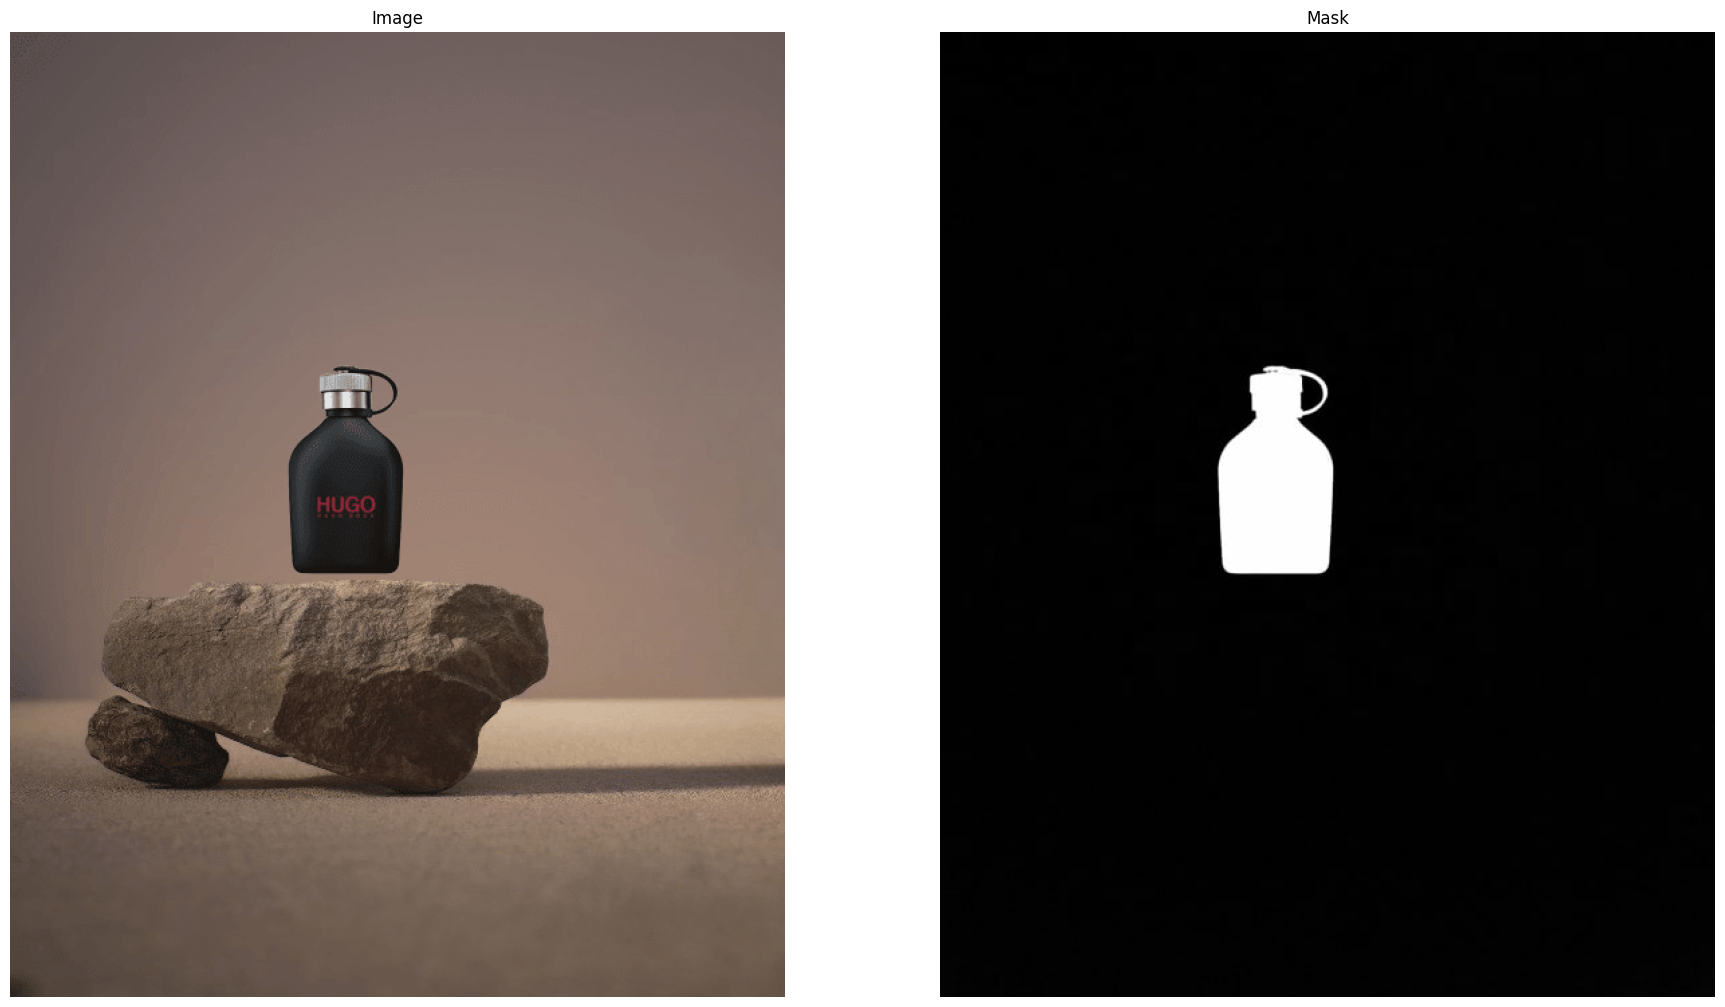

In [53]:
plot_image_and_mask(shuffled_images_masks_df, 55907)


### Remove duplicates

In [101]:
import pandas as pd
import hashlib

def compute_md5(image_path):
    """Compute the MD5 hash of the image at the given path."""
    try:
        with open(image_path, 'rb') as f:
            data = f.read()
        return hashlib.md5(data).hexdigest()
    except FileNotFoundError:
        return None

def remove_duplicate_images(df, image_col):
    """Remove duplicate images based on their MD5 hash."""
    # Compute MD5 hash for each image and store it in a new column
    df['md5'] = df[image_col].apply(compute_md5)

    # Remove rows with invalid image paths
    df = df.dropna(subset=['md5'])

    # Drop duplicates based on the MD5 hash column
    df = df.drop_duplicates(subset=['md5']).reset_index(drop=True)

    # Drop the MD5 hash column
    df = df.drop(columns=['md5'])

    return df

# Example usage
# Load the DataFrame from a CSV file (ensure the path is correct)
df = pd.read_csv('.\\dataset-csv\\seg_img-mask.csv')

# Clean the DataFrame by removing duplicate images
df_cleaned = remove_duplicate_images(df, 'images_path')

# Save the cleaned DataFrame to a new CSV file
df_cleaned.to_csv('.\\dataset-csv\\cleaned_train_data.csv', index=False)


In [102]:
df_cleaned.shape

(15036, 3)